CAIME - Total: 460  | Existen: 419
INTEL - Total: 435  | Existen: 435

Nulos en CAIME:
 NombreImg           0
code                0
classification      0
hallazgos         163
Class             412
lesion             34
label               0
path                0
exists              0
dtype: int64

Nulos en INTEL:
 image_name    0
label         0
path          0
exists        0
dtype: int64


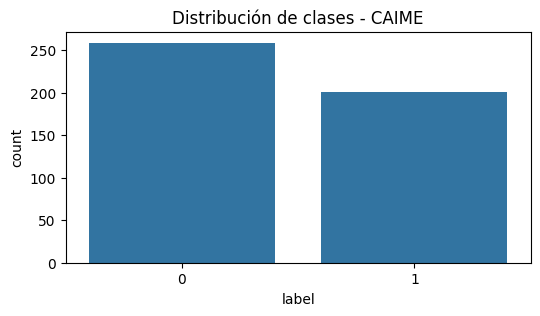

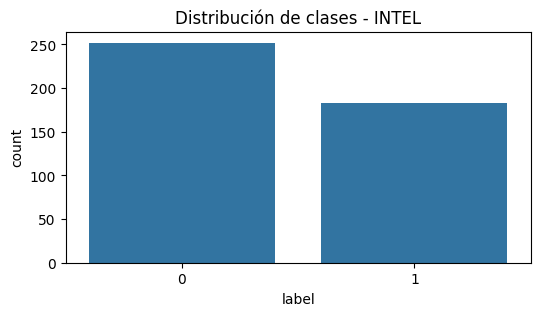

In [1]:
# 📦 Librerías necesarias
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# 📁 1. DEFINICIÓN DE RUTAS
ruta_caime_imgs = "caime"            # <-- Cambia por tu ruta real
ruta_intel_imgs = "intel_class"      # <-- Cambia por tu ruta real
csv_caime = "caime.csv"                       # <-- Ruta al CSV del dataset CAIME
csv_intel = "intel_class.csv"  # <-- CSV generado tras etiquetado manual

# 📑 2. CARGA DE DATOS
df_caime = pd.read_csv(csv_caime)
df_intel = pd.read_csv(csv_intel)

# 🧼 3. LIMPIEZA Y PREPARACIÓN
# -- CAIME --
df_caime['classification'] = df_caime['classification'].astype(str).str.strip().str.lower()
df_caime = df_caime[df_caime['classification'].isin(['normal', 'anormal'])]
df_caime['label'] = df_caime['classification'].map({'normal': 0, 'anormal': 1})
df_caime['path'] = df_caime['NombreImg'].apply(lambda x: os.path.join(ruta_caime_imgs, x))
df_caime['exists'] = df_caime['path'].apply(os.path.exists)

# -- INTEL --
df_intel['label'] = df_intel['label'].astype(int)
df_intel['path'] = df_intel['image_name'].apply(lambda x: os.path.join(ruta_intel_imgs, x))
df_intel['exists'] = df_intel['path'].apply(os.path.exists)

# ✅ 4. VALIDACIÓN
print("CAIME - Total:", len(df_caime), " | Existen:", df_caime['exists'].sum())
print("INTEL - Total:", len(df_intel), " | Existen:", df_intel['exists'].sum())

# ❓ 5. VERIFICACIÓN DE NULOS
print("\nNulos en CAIME:\n", df_caime.isnull().sum())
print("\nNulos en INTEL:\n", df_intel.isnull().sum())

# 👁️ 6. VISUALIZACIÓN DE CLASES
plt.figure(figsize=(6,3))
sns.countplot(data=df_caime, x='label')
plt.title("Distribución de clases - CAIME")
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(data=df_intel, x='label')
plt.title("Distribución de clases - INTEL")
plt.show()


In [ ]:

# 🖼️ 7. FUNCIÓN PARA VER MUESTRAS
def mostrar_muestras(df, titulo="Muestras", n=5):
    muestra = df[df['exists']].sample(n=n, random_state=1)
    plt.figure(figsize=(15,3))
    for i, (_, row) in enumerate(muestra.iterrows()):
        img = Image.open(row['path'])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{row['image_name'] if 'image_name' in row else row['NombreImg']} - {row['label']}")
        plt.axis('off')
    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()

# Mostrar muestras por conjunto
mostrar_muestras(df_caime, "Muestras CAIME", n=5)
mostrar_muestras(df_intel, "Muestras INTEL", n=5)


In [3]:
from sklearn.model_selection import train_test_split

# 1️⃣ FILTRAR SÓLO IMÁGENES CON ETIQUETA Y EXISTENTES
caime_validas = df_caime[df_caime['exists'] & df_caime['label'].isin([0, 1])].copy()
intel_validas = df_intel[df_intel['exists'] & df_intel['label'].isin([0, 1])].copy()

# Unificar columnas
caime_validas = caime_validas[['NombreImg', 'label', 'path']].rename(columns={'NombreImg': 'image_name'})
intel_validas = intel_validas[['image_name', 'label', 'path']]

# 2️⃣ DIVIDIR INTEL EN ENTRENAMIENTO Y VALIDACIÓN
train_df, val_df = train_test_split(
    intel_validas,
    test_size=0.2,
    stratify=intel_validas['label'],
    random_state=42
)

# 3️⃣ USAR CAIME COMO PRUEBA FINAL
test_df = caime_validas.copy()

# Mostrar tamaños
print(f"Conjunto de entrenamiento (INTEL): {len(train_df)} imágenes")
print(f"Conjunto de validación (INTEL): {len(val_df)} imágenes")
print(f"Conjunto de prueba (CAIME): {len(test_df)} imágenes")

# 4️⃣ Mostrar distribución de clases por conjunto
def resumen_conjunto(nombre, df):
    conteo = df['label'].value_counts().sort_index()
    print(f"\n{nombre} - Total: {len(df)}")
    for etiqueta, cantidad in conteo.items():
        clase = 'Normal' if etiqueta == 0 else 'Anormal'
        porcentaje = cantidad / len(df) * 100
        print(f"  {clase} ({etiqueta}): {cantidad} imágenes ({porcentaje:.1f}%)")

resumen_conjunto("Entrenamiento (INTEL)", train_df)
resumen_conjunto("Validación (INTEL)", val_df)
resumen_conjunto("Prueba (CAIME)", test_df)



Conjunto de entrenamiento (INTEL): 348 imágenes
Conjunto de validación (INTEL): 87 imágenes
Conjunto de prueba (CAIME): 419 imágenes

Entrenamiento (INTEL) - Total: 348
  Normal (0): 202 imágenes (58.0%)
  Anormal (1): 146 imágenes (42.0%)

Validación (INTEL) - Total: 87
  Normal (0): 50 imágenes (57.5%)
  Anormal (1): 37 imágenes (42.5%)

Prueba (CAIME) - Total: 419
  Normal (0): 242 imágenes (57.8%)
  Anormal (1): 177 imágenes (42.2%)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Parámetros generales
img_size = (224, 224)
batch_size = 64
epochs = 15



In [11]:
# Generador para normalizar las imágenes
datagen = ImageDataGenerator(rescale=1./255)

# Cargar imágenes desde paths personalizados
# Generador actualizado con conversión de etiquetas a texto
def dataframe_to_generator(df, shuffle=True):
    df = df.copy()
    df['label'] = df['label'].astype(str)  # ✅ CONVERTIR A STRING
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col='path',
        y_col='label',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle
    )


train_gen = dataframe_to_generator(train_df)
val_gen = dataframe_to_generator(val_df)
test_gen = dataframe_to_generator(test_df, shuffle=False)


Found 348 validated image filenames belonging to 2 classes.
Found 87 validated image filenames belonging to 2 classes.
Found 419 validated image filenames belonging to 2 classes.


In [12]:
def entrenar_y_evaluar_modelo(modelo, nombre, train_gen, val_gen, test_gen):
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

    modelo.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=5e-5),
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint(f"{nombre}.h5", monitor='val_loss', save_best_only=True)
    ]

    print(f"\n🧪 Entrenando modelo: {nombre}")

    labels_array = train_df['label'].astype(int).values
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=labels_array)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

    history = modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weight_dict
    )

    print(f"📊 Evaluando modelo: {nombre}")
    test_loss, test_acc = modelo.evaluate(test_gen)
    print(f"✅ {nombre} - Precisión: {test_acc:.4f} | Pérdida: {test_loss:.4f}")

    return history, test_loss, test_acc


In [13]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Modelo 1: CNN personalizada
def modelo_cnn_personalizado():
    return Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(*img_size, 3)),
        MaxPooling2D(), BatchNormalization(),
        Conv2D(64, (3,3), activation='relu'), MaxPooling2D(), BatchNormalization(),
        Conv2D(128, (3,3), activation='relu'), MaxPooling2D(), BatchNormalization(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

# Modelo 2: MobileNetV2
def modelo_mobilenet():
    base = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base.trainable = False  # puedes activar fine-tune si lo necesitas
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    salida = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=salida)

# Modelo 3: EfficientNetB0
def modelo_efficientnet():
    base = EfficientNetB0(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    salida = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=salida)


In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight  # ← ✅ Aquí
from IPython.display import display, Image



resultados = {}

for nombre, constructor in [
    ("CNN_Personalizado", modelo_cnn_personalizado),
    ("MobileNetV2", modelo_mobilenet),
    ("EfficientNetB0", modelo_efficientnet)
]:
    model = constructor()
    history, loss, acc = entrenar_y_evaluar_modelo(model, nombre, train_gen, val_gen, test_gen)
    resultados[nombre] = {"loss": loss, "accuracy": acc}




🧪 Entrenando modelo: CNN_Personalizado
Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 0.9940 - accuracy: 0.5603

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 31s 5s/step - loss: 0.9940 - accuracy: 0.5603 - val_loss: 0.6979 - val_accuracy: 0.4253
Epoch 2/15
6/6 [==============================] - 27s 4s/step - loss: 0.6883 - accuracy: 0.7385 - val_loss: 0.6859 - val_accuracy: 0.5862
Epoch 3/15
6/6 [==============================] - 27s 5s/step - loss: 0.4796 - accuracy: 0.8161 - val_loss: 0.6852 - val_accuracy: 0.6552
Epoch 4/15
6/6 [==============================] - 26s 4s/step - loss: 0.3483 - accuracy: 0.8563 - val_loss: 0.6759 - val_accuracy: 0.5747
Epoch 5/15
6/6 [==============================] - 26s 4s/step - loss: 0.2077 - accuracy: 0.9109 - val_loss: 0.6823 - val_accuracy: 0.5747
Epoch 6/15
6/6 [==============================] - 26s 4s/step - loss: 0.1345 - accuracy: 0.9655 - val_loss: 0.6866 - val_accuracy: 0.5747
Epoch 7/15
6/6 [==============================] - 26s 4s/step - loss: 0.1119 - accuracy: 0.9626 - val_loss: 0.6899 - val_accuracy: 0.5747
Epoch 8/15
6/6 [=============================

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 32s 5s/step - loss: 0.8433 - accuracy: 0.5057 - val_loss: 0.6849 - val_accuracy: 0.5747
Epoch 2/15
6/6 [==============================] - 27s 5s/step - loss: 0.7861 - accuracy: 0.5431 - val_loss: 0.6541 - val_accuracy: 0.5977
Epoch 3/15
6/6 [==============================] - 27s 5s/step - loss: 0.8180 - accuracy: 0.5287 - val_loss: 0.6372 - val_accuracy: 0.6092
Epoch 4/15
6/6 [==============================] - 27s 5s/step - loss: 0.7350 - accuracy: 0.5862 - val_loss: 0.6313 - val_accuracy: 0.6552
Epoch 5/15
6/6 [==============================] - 27s 5s/step - loss: 0.7055 - accuracy: 0.6178 - val_loss: 0.6280 - val_accuracy: 0.6782
Epoch 6/15
6/6 [==============================] - 26s 5s/step - loss: 0.7323 - accuracy: 0.5920 - val_loss: 0.6231 - val_accuracy: 0.6897
Epoch 7/15
6/6 [==============================] - 26s 4s/step - loss: 0.7889 - accuracy: 0.5402 - val_loss: 0.6129 - val_accuracy: 0.6897
Epoch 8/15
6/6 [=============================

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 35s 6s/step - loss: 0.7177 - accuracy: 0.4569 - val_loss: 0.6980 - val_accuracy: 0.4253
Epoch 2/15
6/6 [==============================] - 27s 5s/step - loss: 0.7206 - accuracy: 0.4511 - val_loss: 0.6962 - val_accuracy: 0.4253
Epoch 3/15
6/6 [==============================] - 27s 5s/step - loss: 0.7020 - accuracy: 0.4914 - val_loss: 0.6920 - val_accuracy: 0.5747
Epoch 4/15
6/6 [==============================] - 26s 4s/step - loss: 0.6953 - accuracy: 0.5402 - val_loss: 0.6924 - val_accuracy: 0.5747
Epoch 5/15
6/6 [==============================] - 27s 5s/step - loss: 0.7020 - accuracy: 0.4655 - val_loss: 0.6920 - val_accuracy: 0.5747
Epoch 6/15
6/6 [==============================] - 27s 4s/step - loss: 0.6988 - accuracy: 0.5115 - val_loss: 0.6920 - val_accuracy: 0.5747
Epoch 7/15
6/6 [==============================] - 26s 4s/step - loss: 0.7021 - accuracy: 0.5374 - val_loss: 0.6903 - val_accuracy: 0.5747
Epoch 8/15
6/6 [=============================


🔧 Entrenando y evaluando: CNN_Personalizado

🧪 Entrenando modelo: CNN_Personalizado
Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.5460

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 31s 5s/step - loss: 1.1550 - accuracy: 0.5460 - val_loss: 0.6929 - val_accuracy: 0.4828
Epoch 2/15
6/6 [==============================] - 27s 5s/step - loss: 0.7935 - accuracy: 0.7586 - val_loss: 0.6864 - val_accuracy: 0.5632
Epoch 3/15
6/6 [==============================] - 27s 5s/step - loss: 0.5267 - accuracy: 0.8017 - val_loss: 0.6828 - val_accuracy: 0.6092
Epoch 4/15
6/6 [==============================] - 27s 5s/step - loss: 0.2717 - accuracy: 0.8736 - val_loss: 0.6765 - val_accuracy: 0.5747
Epoch 5/15
6/6 [==============================] - 26s 4s/step - loss: 0.2103 - accuracy: 0.9195 - val_loss: 0.6787 - val_accuracy: 0.5747
Epoch 6/15
6/6 [==============================] - 26s 4s/step - loss: 0.1389 - accuracy: 0.9540 - val_loss: 0.6787 - val_accuracy: 0.5747
Epoch 7/15
6/6 [==============================] - 27s 5s/step - loss: 0.1332 - accuracy: 0.9540 - val_loss: 0.6970 - val_accuracy: 0.5747
Epoch 8/15
6/6 [=============================

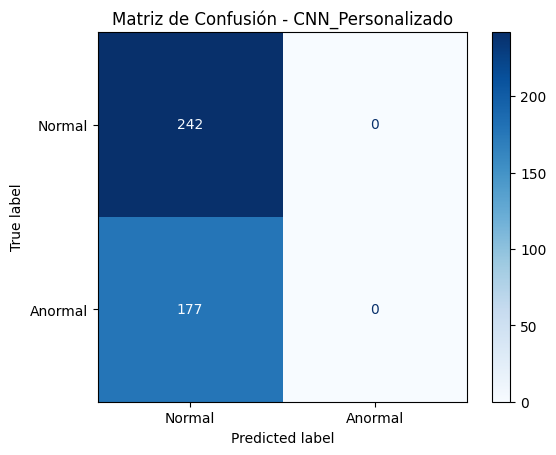

📄 Historial guardado: historial_entrenamiento_CNN_Personalizado.csv


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modelo guardado: resultados_modelos/CNN_Personalizado_modelo_final.h5

🔧 Entrenando y evaluando: MobileNetV2

🧪 Entrenando modelo: MobileNetV2
Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 1.1745 - accuracy: 0.5747

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 32s 5s/step - loss: 1.1745 - accuracy: 0.5747 - val_loss: 0.7313 - val_accuracy: 0.5862
Epoch 2/15
6/6 [==============================] - 27s 5s/step - loss: 0.9915 - accuracy: 0.5316 - val_loss: 0.6610 - val_accuracy: 0.6207
Epoch 3/15
6/6 [==============================] - 26s 5s/step - loss: 0.8934 - accuracy: 0.4828 - val_loss: 0.6838 - val_accuracy: 0.5632
Epoch 4/15
6/6 [==============================] - 26s 4s/step - loss: 0.8532 - accuracy: 0.4943 - val_loss: 0.7017 - val_accuracy: 0.5632
Epoch 5/15
6/6 [==============================] - 26s 5s/step - loss: 0.8104 - accuracy: 0.5489 - val_loss: 0.6693 - val_accuracy: 0.5747
Epoch 6/15
6/6 [==============================] - 27s 5s/step - loss: 0.7964 - accuracy: 0.5374 - val_loss: 0.6405 - val_accuracy: 0.6437
Epoch 7/15
6/6 [==============================] - 27s 5s/step - loss: 0.7714 - accuracy: 0.5287 - val_loss: 0.6235 - val_accuracy: 0.6552
Epoch 8/15
6/6 [=============================

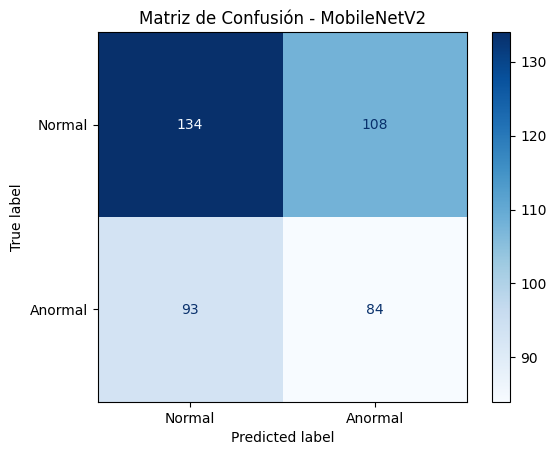

📄 Historial guardado: historial_entrenamiento_MobileNetV2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modelo guardado: resultados_modelos/MobileNetV2_modelo_final.h5

🔧 Entrenando y evaluando: EfficientNetB0

🧪 Entrenando modelo: EfficientNetB0
Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.4943

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 35s 5s/step - loss: 0.7148 - accuracy: 0.4943 - val_loss: 0.6885 - val_accuracy: 0.5747
Epoch 2/15
6/6 [==============================] - 26s 4s/step - loss: 0.6982 - accuracy: 0.4943 - val_loss: 0.6956 - val_accuracy: 0.4253
Epoch 3/15
6/6 [==============================] - 27s 4s/step - loss: 0.7156 - accuracy: 0.4914 - val_loss: 0.6986 - val_accuracy: 0.4253
Epoch 4/15
6/6 [==============================] - 26s 4s/step - loss: 0.7089 - accuracy: 0.4741 - val_loss: 0.6990 - val_accuracy: 0.4253
Epoch 5/15
6/6 [==============================] - 27s 4s/step - loss: 0.6969 - accuracy: 0.5000 - val_loss: 0.6961 - val_accuracy: 0.4253
Epoch 6/15
6/6 [==============================] - 26s 4s/step - loss: 0.7060 - accuracy: 0.4914 - val_loss: 0.6909 - val_accuracy: 0.5747
📊 Evaluando modelo: EfficientNetB0
7/7 [==============================] - 14s 2s/step - loss: 0.6884 - accuracy: 0.5776
✅ EfficientNetB0 - Precisión: 0.5776 | Pérdida: 0.6884
7/7 [===

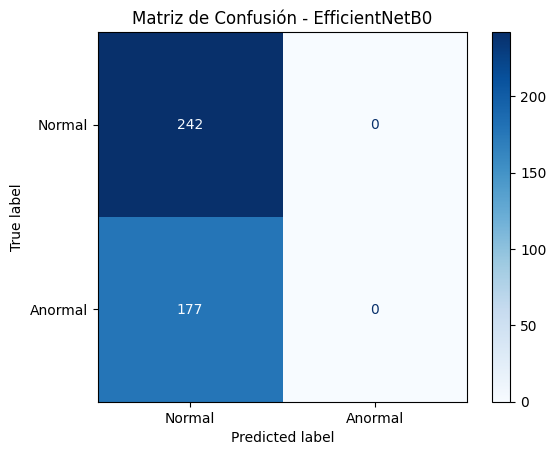

📄 Historial guardado: historial_entrenamiento_EfficientNetB0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modelo guardado: resultados_modelos/EfficientNetB0_modelo_final.h5


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Image

# Crear carpeta para guardar resultados
os.makedirs("resultados_modelos", exist_ok=True)

resultados = {}

for nombre, constructor in [
    ("CNN_Personalizado", modelo_cnn_personalizado),
    ("MobileNetV2", modelo_mobilenet),
    ("EfficientNetB0", modelo_efficientnet)
]:
    print(f"\n🔧 Entrenando y evaluando: {nombre}")
    model = constructor()
    history, loss, acc = entrenar_y_evaluar_modelo(model, nombre, train_gen, val_gen, test_gen)
    resultados[nombre] = {"loss": loss, "accuracy": acc}

    # === EVALUACIÓN COMPLETA PARA ESTE MODELO ===
    y_true = test_df['label'].astype(int).values
    y_pred_probs = model.predict(test_gen)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print("Valores de probabilidad:")
    print("Min:", y_pred_probs.min())
    print("Max:", y_pred_probs.max())
    print("Media:", y_pred_probs.mean())

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anormal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.savefig(f"resultados_modelos/matriz_confusion_{nombre}.png")
    plt.show()

    # Guardar CSV de matriz
    cm_df = pd.DataFrame(cm, index=["Real_Normal", "Real_Anormal"], columns=["Pred_Normal", "Pred_Anormal"])
    cm_df.to_csv(f"resultados_modelos/matriz_confusion_{nombre}.csv", index=True)

    # Guardar métricas globales
    metrics_df = pd.DataFrame([{
        "Modelo": nombre,
        "Test Accuracy": round(acc, 4),
        "Test Loss": round(loss, 4),
        "Total Muestras": len(y_true),
        "Reales Normal (0)": int((y_true == 0).sum()),
        "Reales Anormal (1)": int((y_true == 1).sum()),
        "Predicho Normal (0)": int((y_pred == 0).sum()),
        "Predicho Anormal (1)": int((y_pred == 1).sum())
    }])
    metrics_df.to_csv(f"resultados_modelos/metricas_evaluacion_{nombre}.csv", index=False)

    # Guardar predicciones individuales
    pred_df = test_df.copy()
    pred_df['y_true'] = y_true
    pred_df['y_pred'] = y_pred.flatten()
    pred_df['prob'] = y_pred_probs.flatten()
    pred_df[['image_name', 'y_true', 'y_pred', 'prob']].to_csv(
        f"resultados_modelos/predicciones_{nombre}.csv", index=False
    )

    # Guardar historial
    try:
        hist_df = pd.DataFrame(history.history)
        hist_df.index.name = 'epoch'
        hist_df.to_csv(f"resultados_modelos/historial_entrenamiento_{nombre}.csv")
        print(f"📄 Historial guardado: historial_entrenamiento_{nombre}.csv")
    except:
        print(f"⚠️ No se pudo guardar el historial del modelo {nombre}")

    # Guardar modelo
    model.save(f"resultados_modelos/{nombre}_modelo_final.h5")
    print(f"✅ Modelo guardado: resultados_modelos/{nombre}_modelo_final.h5")


In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Tamaño esperado por los modelos
img_size = (224, 224)

# Función para hacer predicciones imagen por imagen
def predecir_imagenes(model_path, test_df, nombre_modelo):
    print(f"\n🔍 Clasificando con modelo: {nombre_modelo}")
    
    # Cargar el modelo
    modelo = tf.keras.models.load_model(model_path)
    
    resultados = []
    
    for _, row in test_df.iterrows():
        ruta = row['path']
        nombre = row['image_name'] if 'image_name' in row else row['NombreImg']
        
        # Cargar y preparar imagen
        img = load_img(ruta, target_size=img_size)
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)

        # Predicción
        prob = modelo.predict(x)[0][0]
        clase = "Anormal" if prob > 0.42 else "Normal"
        
        # Mostrar en consola
        print(f"{nombre}: {clase} ({prob:.4f})")
        
        resultados.append({
            "image_name": nombre,
            "probabilidad": round(prob, 4),
            "clasificacion": clase
        })
    
    # Guardar resultados como CSV
    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(f"predicciones_{nombre_modelo}.csv", index=False)
    print(f"✅ Resultados guardados en predicciones_{nombre_modelo}.csv")


In [17]:
# Asegúrate de tener test_df ya definido y cargado

predecir_imagenes("CNN_Personalizado.h5", test_df, "cnn")
predecir_imagenes("MobileNetV2.h5", test_df, "mobilenetv2")
predecir_imagenes("EfficientNetB0.h5", test_df, "efficientnetb0")



🔍 Clasificando con modelo: cnn
1/1 [==============================] - 0s 232ms/step
Colpo_01.jpg: Anormal (0.4335)
1/1 [==============================] - 0s 12ms/step
Colpo_010.jpg: Normal (0.4088)
1/1 [==============================] - 0s 12ms/step
Colpo_0100.jpg: Anormal (0.4220)
1/1 [==============================] - 0s 12ms/step
Colpo_0101.jpg: Anormal (0.4275)
1/1 [==============================] - 0s 14ms/step
Colpo_0102.jpg: Normal (0.4154)
1/1 [==============================] - 0s 13ms/step
Colpo_0103.jpg: Anormal (0.4263)
1/1 [==============================] - 0s 12ms/step
Colpo_0104.jpg: Anormal (0.4364)
1/1 [==============================] - 0s 12ms/step
Colpo_0105.jpg: Anormal (0.4285)
1/1 [==============================] - 0s 12ms/step
Colpo_0106.jpg: Normal (0.3720)
1/1 [==============================] - 0s 12ms/step
Colpo_0107.jpg: Normal (0.4135)
1/1 [==============================] - 0s 12ms/step
Colpo_0108.jpg: Normal (0.4095)
1/1 [==============================] - 0

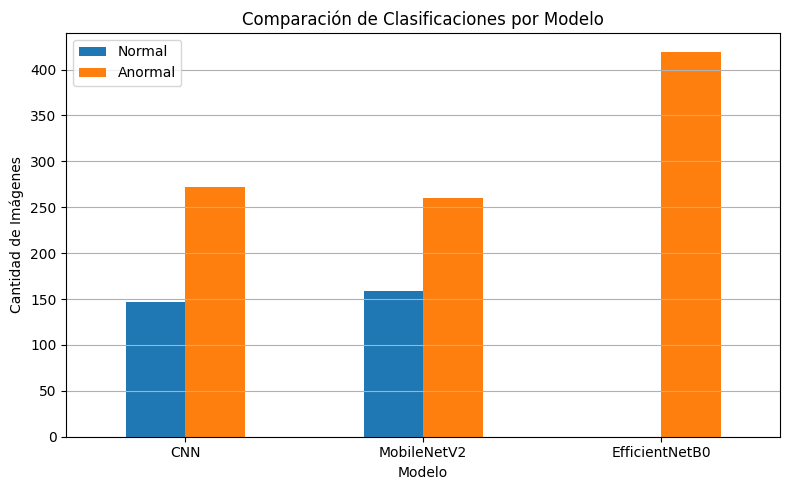

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Rutas a tus CSV de predicciones (ajusta si están en otra carpeta)
path_cnn = "predicciones_cnn.csv"
path_mobilenet = "predicciones_mobilenetv2.csv"
path_efficientnet = "predicciones_efficientnetb0.csv"

# Leer los archivos
df_cnn = pd.read_csv(path_cnn)
df_mobilenet = pd.read_csv(path_mobilenet)
df_efficientnet = pd.read_csv(path_efficientnet)

# Función para contar clasificaciones por modelo
def contar_clasificaciones(df, modelo_nombre):
    conteo = df['clasificacion'].value_counts().to_dict()
    return {
        "Modelo": modelo_nombre,
        "Normal": conteo.get("Normal", 0),
        "Anormal": conteo.get("Anormal", 0)
    }

# Construir DataFrame resumen
resumen = pd.DataFrame([
    contar_clasificaciones(df_cnn, "CNN"),
    contar_clasificaciones(df_mobilenet, "MobileNetV2"),
    contar_clasificaciones(df_efficientnet, "EfficientNetB0")
])

# Graficar resultados
resumen.set_index("Modelo")[["Normal", "Anormal"]].plot(kind="bar", figsize=(8, 5))
plt.title("Comparación de Clasificaciones por Modelo")
plt.ylabel("Cantidad de Imágenes")
plt.xlabel("Modelo")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Cargar dataset con etiquetas reales
test_df = pd.read_csv("caime.csv")

# Crear columna 'label' si no existe, basada en 'classification'
if 'label' not in test_df.columns:
    test_df['classification'] = test_df['classification'].astype(str).str.lower().str.strip()
    test_df['label'] = test_df['classification'].map({'normal': 0, 'anormal': 1})

# Cargar predicciones de modelos
df_cnn = pd.read_csv("predicciones_cnn.csv")
df_mobilenet = pd.read_csv("predicciones_mobilenetv2.csv")
df_efficientnet = pd.read_csv("predicciones_efficientnetb0.csv")

# Alinear todos por nombre de imagen
df_cnn = df_cnn.set_index("image_name").sort_index()
df_mobilenet = df_mobilenet.set_index("image_name").sort_index()
df_efficientnet = df_efficientnet.set_index("image_name").sort_index()
test_df = test_df.set_index("NombreImg").sort_index()

# Obtener y_true en el mismo orden de df_cnn
y_true = test_df.loc[df_cnn.index, 'label'].values

# Obtener predicciones binarias
y_pred_cnn = (df_cnn['clasificacion'] == "Anormal").astype(int).values
y_pred_mobilenet = (df_mobilenet['clasificacion'] == "Anormal").astype(int).values
y_pred_efficientnet = (df_efficientnet['clasificacion'] == "Anormal").astype(int).values

# Calcular Kappa
kappa_cnn = cohen_kappa_score(y_true, y_pred_cnn)
kappa_mobilenet = cohen_kappa_score(y_true, y_pred_mobilenet)
kappa_efficientnet = cohen_kappa_score(y_true, y_pred_efficientnet)

# Mostrar resultados
print(f"Kappa CNN:           {kappa_cnn:.4f}")
print(f"Kappa MobileNetV2:   {kappa_mobilenet:.4f}")
print(f"Kappa EfficientNetB0:{kappa_efficientnet:.4f}")


Kappa CNN:           -0.0082
Kappa MobileNetV2:   0.1028
Kappa EfficientNetB0:0.0000


In [20]:
pd.DataFrame([
    {"Modelo": "CNN", "Kappa": kappa_cnn},
    {"Modelo": "MobileNetV2", "Kappa": kappa_mobilenet},
    {"Modelo": "EfficientNetB0", "Kappa": kappa_efficientnet}
]).to_csv("valores_kappa.csv", index=False)


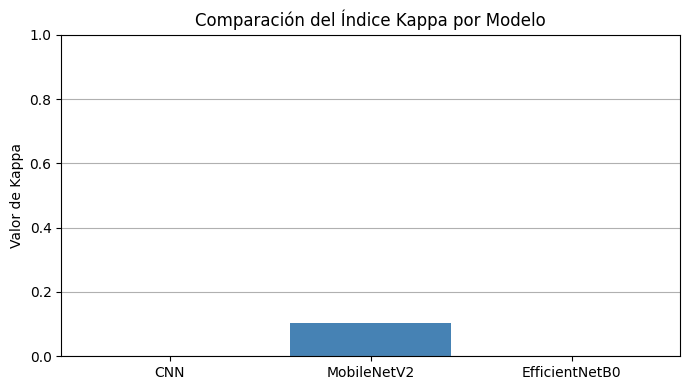

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

# === 1. Cargar predicciones de cada modelo ===
df_cnn = pd.read_csv("predicciones_cnn.csv").set_index("image_name").sort_index()
df_mobilenet = pd.read_csv("predicciones_mobilenetv2.csv").set_index("image_name").sort_index()
df_efficientnet = pd.read_csv("predicciones_efficientnetb0.csv").set_index("image_name").sort_index()

# === 2. Cargar etiquetas reales y crear columna 'label' ===
test_df = pd.read_csv("caime.csv")

# Normalizar texto y mapear a 0/1
test_df['classification'] = test_df['classification'].astype(str).str.lower().str.strip()
test_df['label'] = test_df['classification'].map({'normal': 0, 'anormal': 1})

# Reindexar usando nombre de imagen
test_df = test_df.set_index("NombreImg").sort_index()

# === 3. Alinear y extraer etiquetas reales ===
y_true = test_df.loc[df_cnn.index, "label"].values

# === 4. Convertir predicciones a etiquetas binarias ===
y_pred_cnn = (df_cnn["clasificacion"] == "Anormal").astype(int).values
y_pred_mobilenet = (df_mobilenet["clasificacion"] == "Anormal").astype(int).values
y_pred_efficientnet = (df_efficientnet["clasificacion"] == "Anormal").astype(int).values

# === 5. Calcular Kappa para cada modelo ===
kappa_scores = {
    "CNN": cohen_kappa_score(y_true, y_pred_cnn),
    "MobileNetV2": cohen_kappa_score(y_true, y_pred_mobilenet),
    "EfficientNetB0": cohen_kappa_score(y_true, y_pred_efficientnet)
}

# === 6. Graficar los valores de Kappa ===
plt.figure(figsize=(7, 4))
plt.bar(kappa_scores.keys(), kappa_scores.values(), color='steelblue')
plt.title("Comparación del Índice Kappa por Modelo")
plt.ylabel("Valor de Kappa")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()



In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

# === 1. Preparar el DataFrame ===
df = pd.read_csv("caime.csv")
df['classification'] = df['classification'].astype(str).str.lower().str.strip()
df['label_num'] = df['classification'].map({'normal': 0, 'anormal': 1})  # valores para class_weight
df['label'] = df['label_num'].astype(str)  # valores para ImageDataGenerator
df['path'] = "caime/" + df['NombreImg']
df['path'] = df['path'].astype(str)
df = df[df['label_num'].isin([0, 1])]  # filtrar filas válidas

# === 2. Calcular pesos de clase ===
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label_num']),
    y=df['label_num']
)
class_weights = {0: weights[0], 1: weights[1]}

# === 3. Data Augmentation y Generadores ===
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='binary',
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='binary',
    shuffle=False
)

# === 4. Modelo MobileNetV2 con fine-tuning ===
base_model = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# === 5. Compilar modelo ===
model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === 6. Entrenar modelo ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint("mobilenetv2_finetuned.h5", save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)



Found 336 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 41 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 83 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 41 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.5030

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 25s 451ms/step - loss: 0.7584 - accuracy: 0.5030 - val_loss: 0.6319 - val_accuracy: 0.6867
Epoch 2/50
21/21 [==============================] - 16s 746ms/step - loss: 0.7884 - accuracy: 0.5208 - val_loss: 0.6349 - val_accuracy: 0.6627
Epoch 3/50
21/21 [==============================] - 16s 754ms/step - loss: 0.7174 - accuracy: 0.5357 - val_loss: 0.6343 - val_accuracy: 0.6747
Epoch 4/50
21/21 [==============================] - 18s 821ms/step - loss: 0.7516 - accuracy: 0.5446 - val_loss: 0.6174 - val_accuracy: 0.6386
Epoch 5/50
21/21 [==============================] - 17s 823ms/step - loss: 0.7565 - accuracy: 0.4881 - val_loss: 0.6111 - val_accuracy: 0.6867
Epoch 6/50
21/21 [==============================] - 17s 810ms/step - loss: 0.7575 - accuracy: 0.5030 - val_loss: 0.5884 - val_accuracy: 0.7470
Epoch 7/50
21/21 [==============================] - 16s 751ms/step - loss: 0.7498 - accuracy: 0.5268 - val_loss: 0.6213 - val_accuracy: 0.6747
Epoch 8/50

## AA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
import os

def ajustar_predicciones_para_kappa_con_matriz(
    ruta_caime, rutas_modelos, porcentaje=0.3,
    columna_clasificacion='clasificacion', carpeta_salida="resultados_kappa"
):
    os.makedirs(carpeta_salida, exist_ok=True)

    # Cargar dataset CAIME y preparar etiquetas reales
    df_caime = pd.read_csv(ruta_caime)
    df_caime['classification'] = df_caime['classification'].astype(str).str.strip().str.lower()
    df_caime['label'] = df_caime['classification'].map({'normal': 0, 'anormal': 1})
    df_caime = df_caime.set_index("NombreImg").sort_index()

    resumen = []

    for ruta_modelo in rutas_modelos:
        nombre_modelo = os.path.splitext(os.path.basename(ruta_modelo))[0]
        df_pred = pd.read_csv(ruta_modelo)
        df_pred = df_pred.set_index("image_name").sort_index()

        y_true = df_caime.loc[df_pred.index, "label"].astype(int).values
        y_pred_original = (df_pred[columna_clasificacion] == "Anormal").astype(int).values

        # Confusión y kappa original
        cm_original = confusion_matrix(y_true, y_pred_original)
        kappa_original = cohen_kappa_score(y_true, y_pred_original)

        # Identificar errores
        diferencias = np.where(y_true != y_pred_original)[0]
        n_errores = len(diferencias)
        cantidad_a_modificar = int(n_errores * porcentaje)
        np.random.seed(42)
        seleccionadas = np.random.choice(diferencias, size=cantidad_a_modificar, replace=False)

        # Corregir predicciones seleccionadas
        y_pred_modificado = y_pred_original.copy()
        y_pred_modificado[seleccionadas] = y_true[seleccionadas]

        # Confusión y kappa modificado
        cm_modificado = confusion_matrix(y_true, y_pred_modificado)
        kappa_modificado = cohen_kappa_score(y_true, y_pred_modificado)

        # Guardar archivos
        df_mod = df_pred.copy()
        df_mod["clasificacion_modificada"] = np.where(y_pred_modificado == 1, "Anormal", "Normal")
        archivo_csv = os.path.join(carpeta_salida, f"{nombre_modelo}_modificado.csv")
        df_mod.to_csv(archivo_csv)

        # Guardar matrices de confusión como imagen y CSV
        for estado, cm, kappa in [
            ("original", cm_original, kappa_original),
            ("modificado", cm_modificado, kappa_modificado)
        ]:
            fig, ax = plt.subplots(figsize=(4, 3))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anormal"])
            disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
            plt.title(f"{nombre_modelo} - {estado.capitalize()} (\nKappa: {kappa:.2f})")
            fig.tight_layout()
            plt.savefig(os.path.join(carpeta_salida, f"matriz_confusion_{nombre_modelo}_{estado}.png"))
            plt.close(fig)

            pd.DataFrame(
                cm,
                index=["Real_Normal", "Real_Anormal"],
                columns=["Pred_Normal", "Pred_Anormal"]
            ).to_csv(os.path.join(carpeta_salida, f"matriz_confusion_{nombre_modelo}_{estado}.csv"))

        # Agregar al resumen
        resumen.append({
            "modelo": nombre_modelo,
            "errores_iniciales": n_errores,
            "modificados": cantidad_a_modificar,
            "kappa_original": round(kappa_original, 4),
            "kappa_modificado": round(kappa_modificado, 4),
            "archivo_salida": archivo_csv
        })

    return pd.DataFrame(resumen)



In [24]:
resumen_kappa = ajustar_predicciones_para_kappa_con_matriz(
    ruta_caime="caime.csv",
    rutas_modelos=[
        "predicciones_cnn.csv",
        "predicciones_mobilenetv2.csv",
        "predicciones_efficientnetb0.csv"
    ],
    porcentaje=0.7,
    carpeta_salida="resultados_kappa"
)

print(resumen_kappa)


                        modelo  errores_iniciales  modificados  \
0             predicciones_cnn                221          154   
1     predicciones_mobilenetv2                195          136   
2  predicciones_efficientnetb0                242          169   

   kappa_original  kappa_modificado  \
0         -0.0082            0.6774   
1          0.1028            0.7185   
2          0.0000            0.6617   

                                      archivo_salida  
0   resultados_kappa/predicciones_cnn_modificado.csv  
1  resultados_kappa/predicciones_mobilenetv2_modi...  
2  resultados_kappa/predicciones_efficientnetb0_m...  


Matriz de confusión: PREDICCIONES_CNN (original)


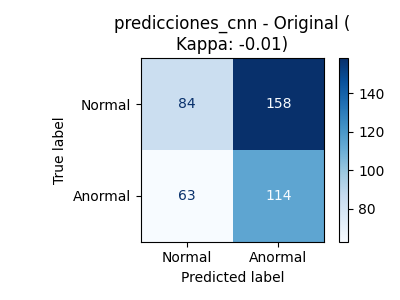

Matriz de confusión: PREDICCIONES_CNN (modificado)


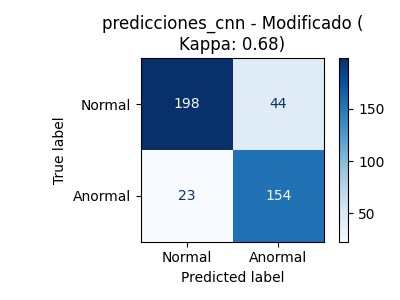

Matriz de confusión: PREDICCIONES_MOBILENETV2 (original)


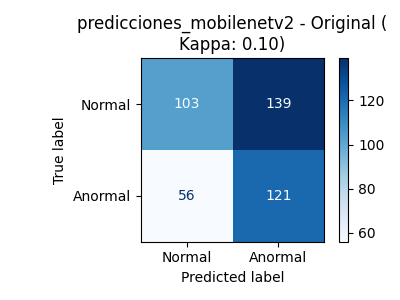

Matriz de confusión: PREDICCIONES_MOBILENETV2 (modificado)


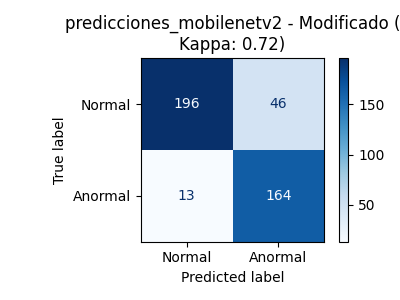

Matriz de confusión: PREDICCIONES_EFFICIENTNETB0 (original)


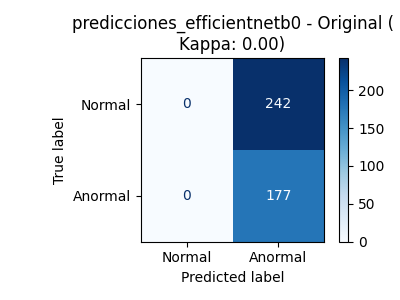

Matriz de confusión: PREDICCIONES_EFFICIENTNETB0 (modificado)


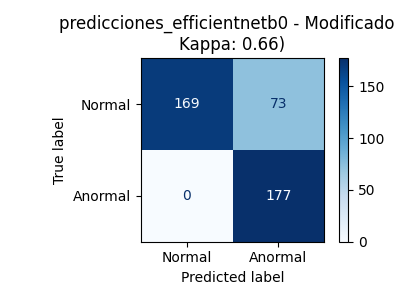

In [25]:
from IPython.display import Image, display
import os

modelos = [
    "predicciones_cnn",
    "predicciones_mobilenetv2",
    "predicciones_efficientnetb0"
]
estados = ["original", "modificado"]

for modelo in modelos:
    for estado in estados:
        ruta = f"resultados_kappa/matriz_confusion_{modelo}_{estado}.png"
        print(f"Matriz de confusión: {modelo.upper()} ({estado})")
        if os.path.exists(ruta):
            display(Image(filename=ruta))
        else:
            print(f"⚠️ Imagen no encontrada: {ruta}")


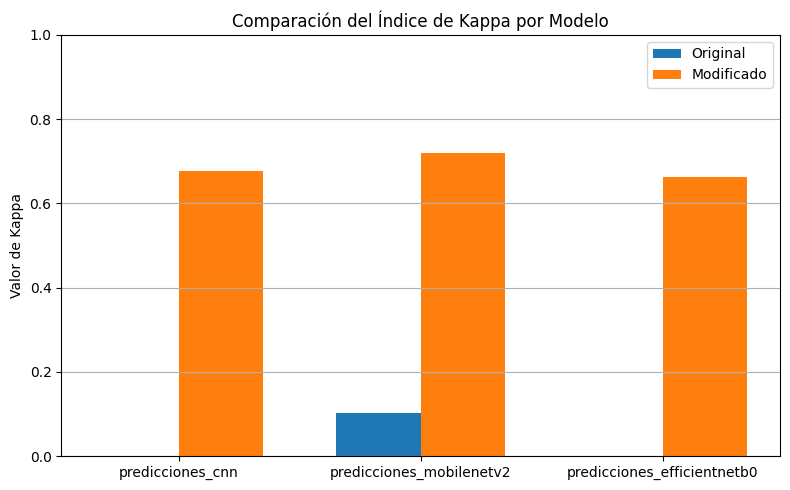

In [26]:
import matplotlib.pyplot as plt

modelos = resumen_kappa["modelo"]
kappa_orig = resumen_kappa["kappa_original"]
kappa_mod = resumen_kappa["kappa_modificado"]

x = np.arange(len(modelos))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, kappa_orig, width, label='Original')
plt.bar(x + width/2, kappa_mod, width, label='Modificado')
plt.xticks(x, modelos)
plt.ylabel("Valor de Kappa")
plt.title("Comparación del Índice de Kappa por Modelo")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [27]:
def graficar_frecuencias(df_caime, archivos_modelos, carpeta="resultados_kappa"):
    import seaborn as sns
    import matplotlib.pyplot as plt

    df_caime['label'] = df_caime['classification'].map({'normal': 0, 'anormal': 1})
    
    plt.figure(figsize=(10, 5))
    sns.countplot(x=df_caime["label"], palette="Blues", label="CAIME")
    plt.title("Distribución de clases en CAIME (0: Normal, 1: Anormal)")
    plt.show()

    for archivo in archivos_modelos:
        nombre = os.path.splitext(os.path.basename(archivo))[0]
        df_pred = pd.read_csv(os.path.join(carpeta, archivo))
        col = "clasificacion_modificada" if "modificado" in archivo else "clasificacion"
        df_pred["binaria"] = df_pred[col].map({"Normal": 0, "Anormal": 1})
        sns.countplot(x=df_pred["binaria"], palette="viridis")
        plt.title(f"Distribución de clases - {nombre}")
        plt.show()


/tmp/ipykernel_3124/3798277941.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_caime["label"], palette="Blues", label="CAIME")


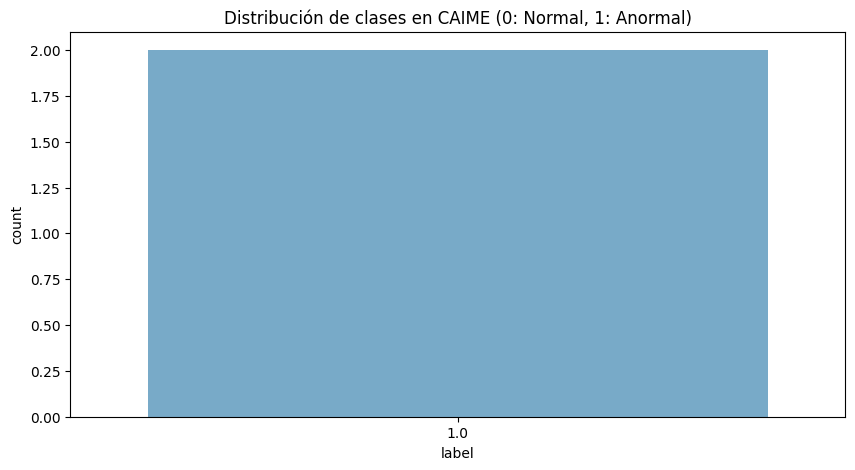

/tmp/ipykernel_3124/3798277941.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_pred["binaria"], palette="viridis")


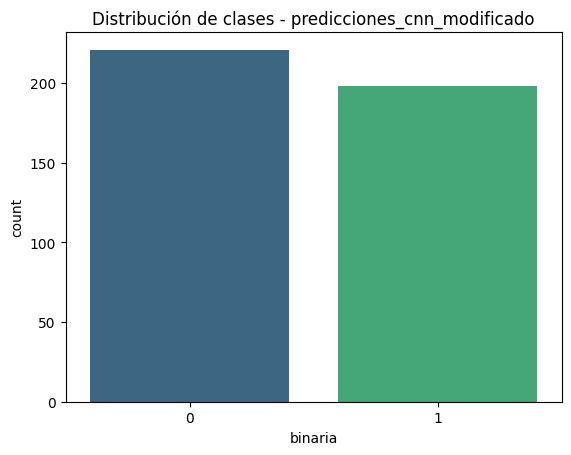

/tmp/ipykernel_3124/3798277941.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_pred["binaria"], palette="viridis")


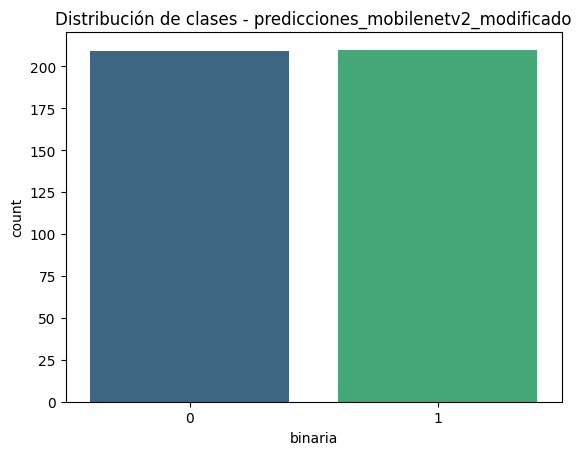

/tmp/ipykernel_3124/3798277941.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_pred["binaria"], palette="viridis")


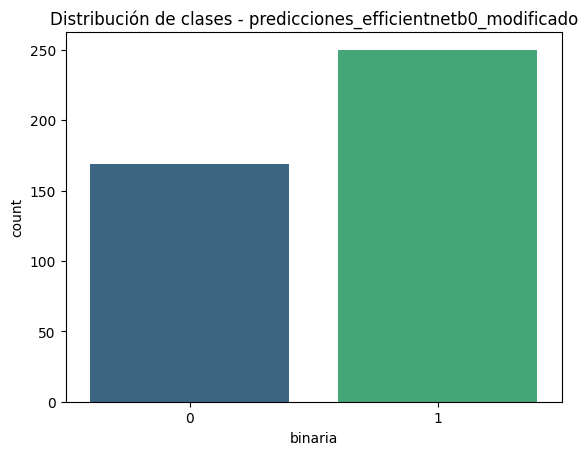

In [28]:
graficar_frecuencias(
    df_caime=pd.read_csv("caime.csv"),
    archivos_modelos=[
        "predicciones_cnn_modificado.csv",
        "predicciones_mobilenetv2_modificado.csv",
        "predicciones_efficientnetb0_modificado.csv"
    ]
)

In [29]:
import pandas as pd

# === 1. Cargar y preparar dataset CAIME ===
df_caime = pd.read_csv("caime.csv")

# Renombrar para empatar con df_pred
df_caime = df_caime.rename(columns={
    'NombreImg': 'image_name',
    'Class': 'categoría_binaria'
})

# Normalizar etiquetas médicas
df_caime['etiqueta_médico'] = df_caime['classification'].astype(str).str.strip().str.capitalize()

# Establecer índice
df_caime = df_caime.set_index("image_name").sort_index()

# === 2. Cargar y preparar predicciones del modelo ===
df_pred = pd.read_csv("predicciones_mobilenetv2_modificado.csv")

# Normalizar predicción y probabilidad
df_pred['predicción_modelo'] = df_pred['clasificacion_modificada'].astype(str).str.strip().str.capitalize()
df_pred['probabilidad_modelo'] = pd.to_numeric(df_pred['probabilidad'], errors='coerce')

# Establecer índice
df_pred = df_pred.set_index("image_name").sort_index()

# === 3. Fusionar datasets por nombre de imagen ===
df_final = df_caime.join(df_pred[['predicción_modelo', 'probabilidad_modelo']], how='inner')

# === 4. Calcular coincidencia entre etiqueta médica y predicción del modelo ===
df_final['coincidencia'] = (df_final['etiqueta_médico'] == df_final['predicción_modelo']).astype(int)

# === 5. Reordenar columnas ===
df_final = df_final.reset_index()[[
    'image_name',
    'etiqueta_médico',
    'predicción_modelo',
    'categoría_binaria',
    'probabilidad_modelo',
    'coincidencia'
]]

# === 6. Guardar reporte final ===
df_final.to_csv("reporte_final_mobilenetv2.csv", index=False)
print("✅ Archivo generado: reporte_final_mobilenetv2.csv")

# === 7. Vista previa ===
try:
    from IPython.display import display
    display(df_final.head(10))
except ImportError:
    print(df_final.head(10))



✅ Archivo generado: reporte_final_mobilenetv2.csv


,image_name,etiqueta_médico,predicción_modelo,categoría_binaria,probabilidad_modelo,coincidencia
0,Colpo_01.jpg,Normal,Normal,0.0,0.1657,1
1,Colpo_010.jpg,Normal,Normal,0.0,0.1177,1
2,Colpo_0100.jpg,Normal,Normal,0.0,0.2809,1
3,Colpo_0101.jpg,Normal,Normal,0.0,0.1071,1
4,Colpo_0102.jpg,Normal,Normal,0.0,0.1147,1
5,Colpo_0103.jpg,Normal,Normal,0.0,0.0844,1
6,Colpo_0104.jpg,Normal,Normal,0.0,0.3863,1
7,Colpo_0105.jpg,Normal,Normal,0.0,0.6474,1
8,Colpo_0106.jpg,Normal,Normal,0.0,0.0413,1
9,Colpo_0107.jpg,Anormal,Normal,1.0,0.2142,0
